<a href="https://colab.research.google.com/github/GawainGan/Causal-Inference/blob/main/Causal%20Inference%20and%20Discovery%20in%20Python/Chap_2_Ladder_of_Causation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy import stats

# Ladder One: Assoication

In [ ]:
class BookSCM:
  """
  这段代码定义了一个名为 BookSCM 的类，
    它是一个结构因果模型（Structural Causal Model, SCM），
    用于模拟两本书A和B的购买行为的相关决策过程。
  代码中包含了随机性的处理、样本生成、以及基于生成的数据计算条件概率
  """
  def __init__(self, random_seed=None):
    self.random_seed = random_seed # 控制随机数
    self.u_0 = stats.uniform() # 创建一个均匀分布对象，用于生成代表变量A的决策过程的随机数
    self.u_1 = stats.norm() # 创建一个正态分布对象，用于生成影响变量B的决策过程的随机数

  def sample(self, sample_size=100):
    """Samples from the SCM"""
    if self.random_seed:
      np.random.seed(self.random_seed)
      u_0 = self.u_0.rvs(sample_size)
      u_1 = self.u_1.rvs(sample_size)
      a = u_0 > .61
      b = (a + .5 * u_1) > .2
      return a, b

In [ ]:
scm = BookSCM(random_seed=45)

In [ ]:
buy_book_a, buy_book_b = scm.sample(100) #  生成100个样本点，然后分别获取购买书A和书B的布尔数组

buy_book_a.shape, buy_book_b.shape

((100,), (100,))

In [ ]:
# buy_book_a[buy_book_b].sum() 计算在购买书B的情况下，也购买书A的样本数量。
# buy_book_a[buy_book_b].shape[0] 计算购买书B的总样本数。

# 计算条件概率
proba_book_a_given_book_b = buy_book_a[buy_book_b].sum() / buy_book_a[buy_book_b].shape[0]

print(f'Probability of buying book A given B: {proba_book_a_given_book_b:0.3f}')

Probability of buying book A given B: 0.638


正如我们所看到的，鉴于我们购买了B书，购买A书的概率为63.8%。这表明两个变量之间存在正关系（如果它们之间没有关联，我们预计结果为50%）。这些结果告诉我们，我们可以仅使用观测数据做出有意义的预测。这种能力是大多数当代（监督）机器学习模型的本质。

# Ladder Two: Intervention

In [ ]:
SAMPLE_SIZE = 100
np.random.seed(45)

In [ ]:
u_0 = np.random.randn(SAMPLE_SIZE)
u_1 = np.random.randn(SAMPLE_SIZE)
a = u_0
b = 5 * a + u_1
r, p = stats.pearsonr(a, b)
print(f'Mean of B before any intervention: {b.mean():.3f}')
print(f'Variance of B before any intervention: {b.var():.3f}')
print(f'Correlation between A and B:\nr = {r:.3f}; p ={p:.3f}\n')

Mean of B before any intervention: -0.620
Variance of B before any intervention: 22.667
Correlation between A and B:
r = 0.978; p =0.000



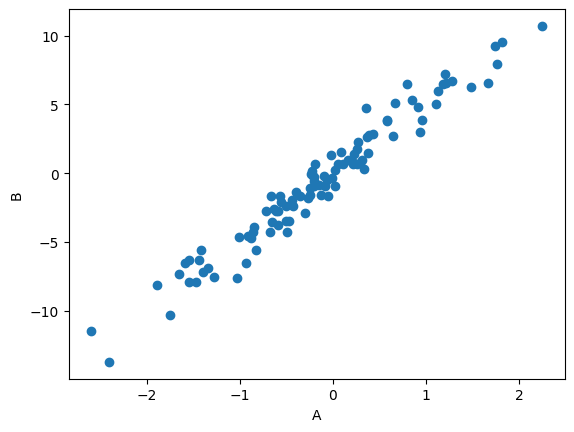

In [ ]:
# plot a abd b
import matplotlib.pyplot as plt
plt.scatter(a, b)
plt.xlabel('A')
plt.ylabel('B')
plt.show()

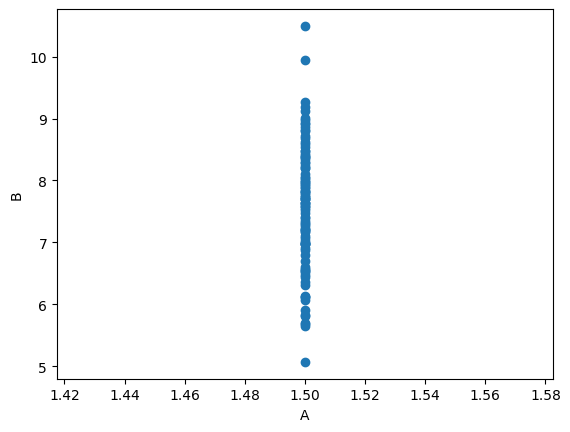

In [ ]:
# intervene on A by fixing its value at 1.5:
a = np.array([1.5] * SAMPLE_SIZE)
b = 5 * a + u_1

plt.scatter(a, b)
plt.xlabel('A')
plt.ylabel('B')
plt.show()

In [ ]:
print(f'Mean of B after the intervention on A: {b.mean():.3f}')
print(f'Variance of B after the intervention on A:{b.var():.3f}\n')

Mean of B after the intervention on A: 7.575
Variance of B after the intervention on A:1.003



平均值和方差都发生了变化。B的新均值比前一个要大得多。这是因为我们对A(1.5)的干预价值比我们对A（以0为中心）的原始分布所期望的要大得多。与此同时，方差缩小了。这是因为A的数值变成了一个（固定的）常数，而唯一存留变异性的B值是来自其随机的前向值(stochastic parent)U1。

In [ ]:
# intervened on B instead
a = u_0
b = np.random.randn(SAMPLE_SIZE)
r, p = stats.pearsonr(a, b)
print(f'Mean of B after the intervention on B: {b.mean():.3f}')
print(f'Variance of B after the intervention on B: {b.var():.3f}')
print(f'Correlation between A and B after intervening on B:\nr ={r:.3f}; p = {p:.3f}\n')

Mean of B after the intervention on B: 0.186
Variance of B after the intervention on B: 0.995
Correlation between A and B after intervening on B:
r =-0.023; p = 0.821



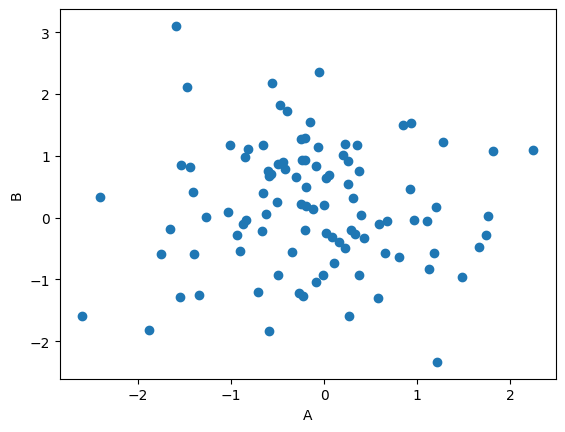

In [ ]:
plt.scatter(a, b)
plt.xlabel('A')
plt.ylabel('B')
plt.show()

Note that the correlation between A and B dropped to almost zero ( r=−.023 ), and the corresponding p -value indicates a lack of significance ( p=.821 ). This indicates that after the intervention, A and B became (linearly) independent. This result suggests that there is no causal link from B to A . At the same time, previous results demonstrated that intervening on A changes B , indicating that there is a causal link from A to B

# Ladder Three: Counterfactuals

In [3]:
class CounterfactualSCM:
  # adbuction 溯因
  def abduct(self, t, y):
    """
    Compute the value of exogenous variables `U`, given thenvalue for treatment `T` and the actual outcome whicich is t and y

    Take the example of the coffee:
    U: the value revalue person's coffee-sensitivity
    T: the treatment of drinking coffe. 1 is drink, 0 is not drink
    y: the actual outcome of drinking coffee. 1 is uncomfortable, 0 is comfortable
    """
    return (t + y - 1)/(2*t - 1)
  # 修改 do-factor
  def modify(self, t):
    """
    modify the def by assign the `t` to `T`
    The `t` is the treatment at the counterfactual of interest (or the treatment we did not apply to)

    Here t can be 0 if the original treament is 1, and vice versa
    """
    return lambda u: t * u + (t - 1) * (u - 1)
  # 预测
  def predict(self, u, t):
    return self.modify(t)(u)

In [4]:
coffee = CounterfactualSCM()
t = 1
y = 1
# which means `person drink the coffee` & `people fell uncomfortable`

In [5]:
u = coffee.abduct(t=t, y=y)
# get the result for the first step of abduction, 1 means that the person is coffee-sensitive
u

1.0

In [6]:
# apply the counterfactual prediction
coffee.predict(u=u, t=0)
# here u is the result from the abduction, which is 1
# and t = 0 which we apply the counterfactual treatment
# and get the result of y for the counterfactual treatment

0.0